# 0) Importing the libraries

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

sns.set()

credit_card_path = Path("..", "data", "AER_credit_card_data.csv")
df = pd.read_csv(credit_card_path)

Data preparation: 
- Create the target variable by mapping yes to 1 and no to 0.
- Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [112]:
df["target"] = df["card"].apply(lambda x: 1 if (x == "yes") else 0)
df[["target", "card"]].head(10)

,target,card
0,1,yes
1,1,yes
2,1,yes
3,1,yes
4,1,yes
5,1,yes
6,1,yes
7,1,yes
8,1,yes
9,1,yes


In [113]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_valid = train_test_split(df_full_train, test_size=0.25, random_state=1)

# 1) Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the card variable.
- Use the training dataset for that.


Which numerical variable (among the following 4) has the highest AUC?

- [ ] reports
- [ ] dependents
- [ ] active
- [X] share

In [114]:
from sklearn.metrics import roc_auc_score
numeric_variables = ["reports", "dependents", "active", "share"]

for feature in numeric_variables:
    result = roc_auc_score(df_train["target"], df_train[feature])
    print(f"{feature}: {abs(result)}")

reports: 0.28333701393106236
dependents: 0.46722427722262094
active: 0.6043173411362006
share: 0.989183643423692


# Training the model
From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [115]:
model_cols = ["reports", "age", "income", "share", "expenditure",
              "dependents", "months", "majorcards", "active", "owner",
              "selfemp"]

y_train, y_valid, y_test = map(lambda x: x["target"].values, [df_train, df_valid, df_test])
df_train, df_valid, df_test = map(lambda x: x[model_cols], [df_train, df_valid, df_test])

In [116]:
df_train.head()

,reports,age,income,share,expenditure,dependents,months,majorcards,active,owner,selfemp
1105,3,40.50000,4.0128,0.000299,0.00000,1,12,1,17,no,no
431,1,32.33333,6.0000,0.000200,0.00000,4,18,1,4,yes,no
407,1,29.16667,2.2000,0.038205,69.79333,0,49,1,7,no,no
1217,1,54.66667,7.2900,0.106536,647.20670,2,78,1,9,yes,no
1133,0,25.00000,3.3984,0.000353,0.00000,2,29,0,4,yes,no


In [117]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [118]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer()
train_dicts = df_train.to_dict(orient="records")
valid_dicts = df_valid.to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)
X_valid = dv.transform(valid_dicts)

# 2) Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- [ ] 0.615
- [ ] 0.515
- [ ] 0.715
- [X] 0.995


In [119]:
model.fit(X_train, y_train)
y_prob_valid = model.predict_proba(X_valid)[:, 1]
print(f"AUC: {round(roc_auc_score(y_valid, y_prob_valid), 3)}")

AUC: 0.995


# 3) Question 3

Now let's compute precision and recall for our model.

- Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- [ ] 0.1
- [X] 0.3
- [ ] 0.6
- [ ] 0.8

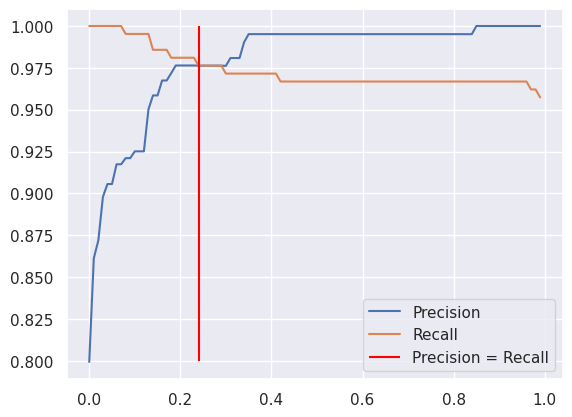

In [120]:
from sklearn.metrics import precision_score, recall_score

list_thresholds = np.arange(0.0, 1.0, 0.01)
precision_list = []
recall_list = []
for threshold in list_thresholds:
    pred = y_prob_valid >= threshold
    precision = precision_score(y_valid, pred)
    recall = recall_score(y_valid, pred)
    precision_list.append(precision)
    recall_list.append(recall)

equal_precision_recall = list_thresholds[np.argmax(np.array(precision_list) == np.array(recall_list))]
plt.plot(list_thresholds, precision_list, label="Precision")
plt.plot(list_thresholds, recall_list, label="Recall")
plt.vlines(x=equal_precision_recall, ymin=0.8,
           ymax=1, color = 'red', label="Precision = Recall")
plt.legend()
plt.show()

# 4) Question 4

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- [ ] 0.1
- [X] 0.4
- [ ] 0.6
- [ ] 0.7

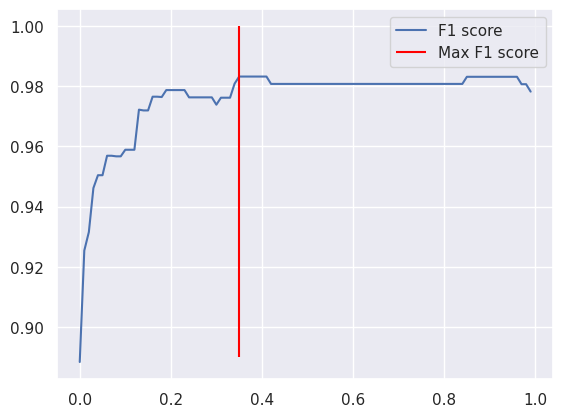

In [121]:
from sklearn.metrics import f1_score

list_thresholds = np.arange(0.0, 1.0, 0.01)
f1_list = []
for threshold in list_thresholds:
    pred = y_prob_valid >= threshold
    f1 = f1_score(y_valid, pred)
    f1_list.append(f1)

plt.plot(list_thresholds, f1_list, label="F1 score")

plt.vlines(x=list_thresholds[np.argmax(f1_list)], ymin=0.89,
           ymax=1, color = 'red', label="Max F1 score")

plt.legend()
plt.show()

# Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

- [ ] 0.003
- [ ] 0.014
- [ ] 0.09
- [ ] 0.24


In [129]:
from typing import Tuple, Protocol

class ScikitModel(Protocol):
    def fit(self, X, y, sample_weight=None): ...
    def predict(self, X): ...


def train_model(df_train: pd.DataFrame,y_train: pd.DataFrame, model: ScikitModel
                ) -> Tuple[DictVectorizer, ScikitModel]:
    
    dicts = df_train.to_dict(orient="records")
    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)
    
    model.fit(X_train, y_train)
    
    return dv, model

def predict_model(df: pd.DataFrame, dv: DictVectorizer, model: ScikitModel) -> pd.DataFrame:
    
    dicts = df.to_dict(orient="records")
    
    X = dv.transform(dicts)
    return model.predict_proba(X)[:, 1]

In [130]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_score_list = []

for train_idx, valid_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_valid = df_full_train.iloc[valid_idx]
    
    y_train_cv = df_train.target.values
    y_valid_cv = df_valid.target.values
    
    df_train = df_train[model_cols]
    df_valid = df_valid[model_cols]
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    
    dv, model = train_model(df_train, y_train_cv, model)
    
    y_pred = predict_model(df_valid, dv, model)
    
    auc_score_list.append(roc_auc_score(y_valid_cv, y_pred))

print(f"AUC: {np.mean(auc_score_list):.03f} +/- {np.std(auc_score_list):.03f}")

AUC: 0.996 +/- 0.003


# 6) Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- [ ] 0.01
- [ ] 0.1
- [X] 1
- [ ] 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [133]:
from sklearn.model_selection import KFold


kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_mean_cv, auc_std_cv = [], []

C_list = [0.01, 0.1, 1, 10]

for c_value in C_list:
    auc_score_list = []
    for train_idx, valid_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_valid = df_full_train.iloc[valid_idx]
        
        y_train_cv = df_train.target.values
        y_valid_cv = df_valid.target.values
        
        df_train = df_train[model_cols]
        df_valid = df_valid[model_cols]
        
        model = LogisticRegression(solver='liblinear', C=c_value, max_iter=1000)
        
        dv, model = train_model(df_train, y_train_cv, model)
        
        y_pred = predict_model(df_valid, dv, model)
        
        auc_score_list.append(roc_auc_score(y_valid_cv, y_pred))
    auc_mean_cv.append(np.mean(auc_score_list))
    auc_std_cv.append(np.std(auc_score_list))

for c, mean, std in zip(C_list, auc_mean_cv, auc_std_cv):
    print(f"C = {c}: {mean:.03f} +/- {std:.03f}")

C = 0.01: 0.992 +/- 0.006
C = 0.1: 0.995 +/- 0.004
C = 1: 0.996 +/- 0.003
C = 10: 0.996 +/- 0.003
